# An introduction to Deep Reinforcement Learning

# Agenda
***
1. What is Deep RL?
    * Deep Learning vs Deep Reinforcement Learning
2. Types of learning
    * Supervised vs unsupervised vs RL
    * RL in Humans, why are we so good?
3. Reinforcement Learning Framework
    * Agent, Action, State, Reward
4. Environments & Actions
    * Observability, Single VS Multi Agent, Deterministic/Stochastic, Static/Dynamic, Discrete/Continuous
5. RL in the real world
    * Two open problems:
        * Make better simulations
        * Make algorithms that generalize better from simulation to real world
6. Components of an RL agent
    * Policy, the behavior function, probability of taking $a_t$ when in state $s_t$
    * Value function, how good is each state/action in terms of expected future reward
        * $V_\pi(s)=E\left[\sum_{t=0}^{\infty}\gamma^t r_t\mid s_0 = s\right]$
    * Model, agent's representation of the environment
7. Meaning of Life: Maximize Reward
    * Future reward, discounted reward
8. Robot in a room:
    * Example to show the impact of reward structure and environment on the optimal policy
    * **TODO: Do we need code here?**
        * I am afraid we do!
9. Types of RL (several ways to taxonomize exist!)
    * Model-based
        * learn a model of the world through interaction, then plan ahead using the model
    * Value-based (off policy)
        * Learn the values for states or states/actions
            * Constantly update how good it is to take action $a$ in state $s$
            * Act by choosing the best action in state. Exploration is needed!
    * Policy-based
        * Learning the right behavior function that maps state to action
        * Act by sampling policy, exploration already included
10. Taxonomy by OpenAI
    * Is this needed?

# Grid World
***
Install a library that will help us solve the underlying Markov Decision Processes

In [1]:
%pip install pymdptoolbox

  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25658 sha256=6efd5e475e23f6cb97e4eed636afc19291877c1f54f5772bc936d461d070d901
  Stored in directory: c:\users\nikla\appdata\local\pip\cache\wheels\85\c2\e4\29e0b5aab8da79e0f54cf086f8549d47c824e5242ae687e93a
Successfully built pymdptoolbox
Note: you may need to restart the kernel to use updated packages.Installing collected packages: pymdptoolbox


You should consider upgrading via the 'c:\users\nikla\workspace\jupyter-notebooks\env\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mdptoolbox import mdp

In [2]:
class Gridworld():
    def __init__(self, actions, w=4, h=3, rho=1.0, step_reward=0.0, cell_rewards={},
               terminal_states=[]):
        self.actions = actions
        self.w, self.h = w, h
        self.rho = rho
        self.step_reward = step_reward
        self.cell_rewards = cell_rewards
        self.terminal_states = {tuple(x) for x in terminal_states}

        self.grid = np.zeros((h,w))
        self.states = np.array([[i,j] for i in range(h) for j in range(w)])
        self.num_states = w*h
        self.num_actions = len(actions)
        self.p = np.zeros((self.num_actions, self.num_states, self.num_states), "float32")
        self.r = np.zeros((self.num_actions, self.num_states, self.num_states), "float32")
        self._fill_p()
        self._fill_r()

    def _fill_p(self):
        # computing transition matrix:
        for a in range(self.num_actions):
            for i in range(self.num_states):
                # simulate performing action a_ in state i
                # action a is performed with prob. rho,
                # with prob. 1-rho, any other action is chosen,
                # which results in prob. (1-rho)/(num_moves-1) for
                # a specific action a_ != a
                for a_ in range(self.num_actions):
                    rh, rw = self.make_move(self.actions[a_], self.states[i])
                    j_ = rh*self.w + rw
                    prob = self.rho if a == a_ else (1-self.rho)/(self.num_actions-1)
                    self.p[a, i, j_] += prob

        # make sure we can't ever leave terminal states
        for (i,j) in self.terminal_states:
            # transition probability from state (i,j) to any other state 
            # must be zero, but one for (i,j)
            index = i*self.w+j
            self.p[:,index,:] = 0
            self.p[:, index, index] = 1

    def _fill_r(self):
        # transitions always give step_reward
        self.r.fill(self.step_reward)

        # ending on a rewarded cell gives the corresponding reward
        for (i,j), reward in self.cell_rewards.items():
            self.r[:,:, i*self.w+j] += reward

        # terminal cells do not give ANY reward after having reached them
        for (i,j) in self.terminal_states:
            k = i*self.w+j
            self.r[:, k, :] = 0

    def make_move(self, move, state):
        return np.clip(np.array(move)+np.array(state), 0, (self.h-1, self.w-1))

    def _plot_policy(self, policy):
        a_l = 0.6 # arrow length
        for (i,j), a in list(zip(self.states, policy)):
            if (i,j) in self.terminal_states: continue
           
            dh, dw = self.actions[a]
            if dh == -1:
                y_off = 1 - (1-a_l)/2.
                x_off = 0.5
            elif dh == 0:
                y_off = 0.5
                if dw == -1:
                    x_off = 1 - (1-a_l)/2.0
                elif dw == 1:
                    x_off = (1-a_l)/2.0
                else: raise ValueError("Invalid action to plot!")
            elif dh == 1:
                y_off = (1-a_l)/2.0
                x_off = 0.5
            else: raise ValueError("Invalid action to plot")
            plt.arrow(j+x_off, i+y_off, dw*a_l, dh*a_l, width=0.1, 
                      head_width=0.4, head_length=0.6*0.35, fc="k", ec="k",
                      length_includes_head=True, linewidth=0, overhang=0.3)
        return

    def _plot_terminal_states(self):
        for (i,j) in self.terminal_states:
            c = plt.Circle((j+0.5,i+0.5), radius=0.3, fill=False, ec="black",
                          lw=3)
            plt.gca().add_patch(c)

    def _plot_rewards(self):
        for (i,j), r in self.cell_rewards.items():
            plt.text(j+0.05,i+0.95, f"{r:.1f}")

    def plot(self, policy=None, start=None, height=None, width=None):
        if height is None and width is None:
            height = self.h
            width = self.w
        if height is None:
            height = self.h*(width/self.w)
        if width is None:
            width = self.w*(height/self.h)
        fig, ax = plt.subplots(figsize=(width, height))
        if policy is not None:
            self._plot_policy(policy)
        self._plot_terminal_states()
        self._plot_rewards()
        plt.xlim(0, self.w)
        plt.ylim(0, self.h)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                        labelbottom=False, right=False, left=False, labelleft=False)
        plt.xticks(range(self.w))
        plt.yticks(range(self.h))
        ax.invert_yaxis()
        plt.grid()
        plt.title("Grid world")
        plt.show()

In [3]:
a = {1,2,3}
for x in a:
    print(x)

1
2
3


In [4]:
w=8; h=3; rho=1; step_reward=0.0;

actions = np.array([
    [-1,0], # UP
    [1,0], # DOWN 
    [0,-1], # Left
    [0,1], # Right
])
cell_rewards={
    (0,3): 1,
    (1,3): -100,
}
terminal_states=[
    #[0,3],
    [1,3],
]

gw  = Gridworld(w=w, h=h, rho=rho, step_reward=step_reward,
                cell_rewards=cell_rewards, actions=actions,
                terminal_states=terminal_states)

  Iteration		Number of different actions
    1		  7
    2		  8
    3		  3
    4		  0
Iterating stopped, unchanging policy found.
(3, 3, 3, 0, 2, 2, 2, 2, 3, 3, 0, 0, 0, 0, 2, 2, 3, 3, 0, 2, 0, 0, 2, 2)


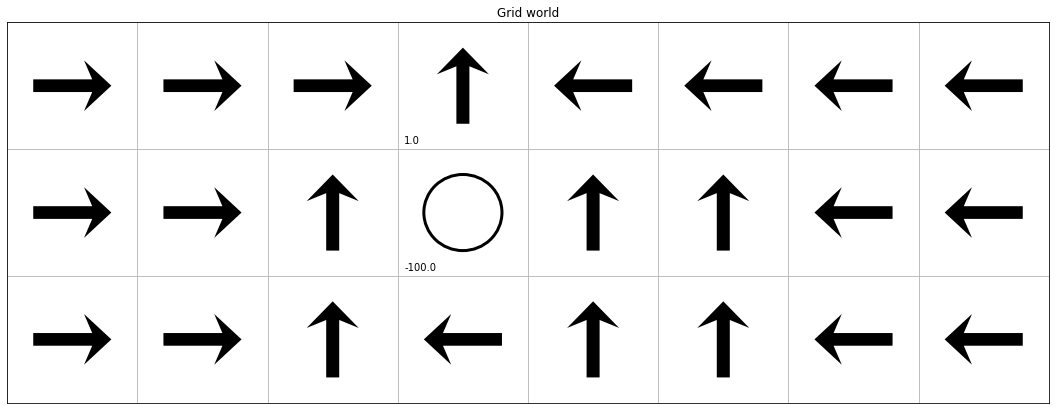

(998.0009999999985,
 998.9999999999985,
 999.9999999999985,
 999.9999999999985,
 999.9999999999985,
 998.9999999999985,
 998.0009999999985,
 997.0029989999986,
 997.0029989999986,
 998.0009999999986,
 998.9999999999986,
 0.0,
 998.9999999999985,
 998.0009999999987,
 997.0029989999987,
 996.0059960009987,
 996.0059960009987,
 997.0029989999987,
 998.0009999999987,
 997.0029989999988,
 998.0009999999986,
 997.0029989999988,
 996.0059960009988,
 995.0099900049978)

In [5]:
#vi = mdp.ValueIteration(gw.p, gw.r, 0.9, max_iter=1e5)
vi = mdp.PolicyIteration(gw.p, gw.r, 0.999)
vi.setVerbose()
vi.run()
print(vi.policy)
gw.plot(policy=vi.policy, height=7)
vi.V

In [120]:
f"{1.00:.2f}"

'1.00'

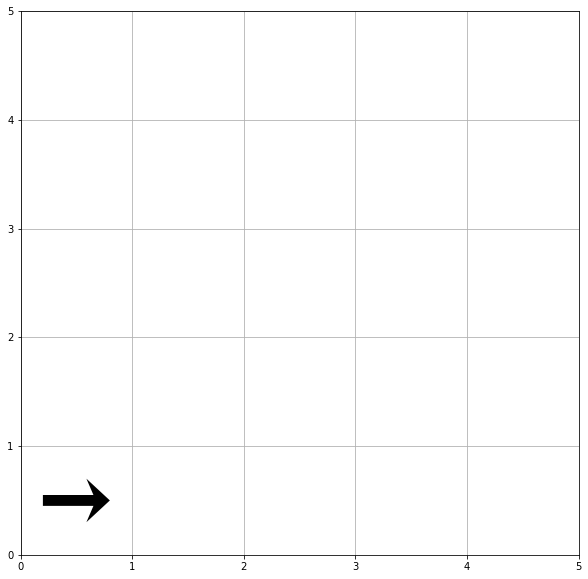

In [109]:
plt.figure(figsize=(10,10))
plt.xlim(0,5)
plt.ylim(0,5)
plt.grid()
plt.arrow(0.2, 0.5, 0.6,0, width=0.1, 
                      head_width=0.4, head_length=0.6*0.35, fc="k", ec="k",
                      length_includes_head=True, linewidth=0, overhang=0.3)
plt.show()